# Model Training and Evaluation

This notebook trains and evaluates multiple classification models using the preprocessed and feature-selected data. We compare different models' performance and select the best performing ones.

Load the preprocessed data from previous steps. The data has already been:
- Split into train/test sets
- Preprocessed (cleaned, normalized)
- Feature selected (using training data only)

Key Features
- **Automatic Classification Detection**: Detects binary vs multiclass automatically
- **Comprehensive Model Support**: Linear, tree-based, SVM, and neural networks
- **Class Imbalance Handling**: SMOTE, class weights, or no handling
- **Cross-Validation**: Stratified k-fold cross-validation
- **Hyperparameter Tuning**: Grid search optimization
- **Progress Tracking**: Clear logging and progress indicators

Models Supported
- **Linear**: Logistic Regression
- **Tree-based**: Random Forest, XGBoost, LightGBM
- **Kernel Methods**: Support Vector Machine
- **Neural Networks**: Multi-layer Perceptron

All training is done using only the training data to prevent data leakage.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
import seaborn as sns
import pickle
from pathlib import Path
import toml
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Import utility functions
import sys
from sklearn.metrics import confusion_matrix
sys.path.append(str(Path().resolve()))
from model_training import (
    detect_classification_type, handle_class_imbalance, 
    ModelFactory, train_model_with_cv, evaluate_model,
    get_class_distribution
)

# Load configuration
config = toml.load('../config.toml')

# Display configuration
print("Model Training Configuration:")
print(f"Models to train: {config['modeling']['models']}")
print(f"Cross-validation folds: {config['modeling']['cv_folds']}")
print(f"Class imbalance handling: {config['modeling']['class_imbalance']}")
print(f"Hyperparameter search method: {config['hyperparameter_tuning']['search_method']}")
print(f"Parallel jobs: {config['hyperparameter_tuning']['n_jobs']}")

# Apply visualization settings from config
if 'visualization' in config:
    if 'dpi' in config['visualization']:
        plt.rcParams['figure.dpi'] = config['visualization']['dpi']
    if 'figure_size' in config['visualization']:
        plt.rcParams['figure.figsize'] = config['visualization']['figure_size']
    if 'color_palette' in config['visualization']:
        sns.set_palette(config['visualization']['color_palette'])

Model Training Configuration:
Models to train: ['linear', 'random_forest', 'xgboost', 'lightgbm', 'svm', 'neural_net']
Cross-validation folds: 5
Class imbalance handling: auto
Hyperparameter search method: grid
Parallel jobs: -1


Load feature-selected data from previous step

In [2]:
# Load feature-selected data from previous step
data_dir = Path('../data/processed')
with open(data_dir / '04_feature_selection.pkl', 'rb') as f:
    feature_data = pickle.load(f)

X_train = feature_data['X_train_selected']
X_test = feature_data['X_test_selected']
y_train = feature_data['y_train']
y_test = feature_data['y_test']
selected_features = feature_data['selected_features']

print("Data loaded successfully!")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Selected features: {len(selected_features)}")

# Detect classification type
classification_type, n_classes = detect_classification_type(y_train)
print(f"\nClassification type: {classification_type}")
print(f"Number of classes: {n_classes}")
print(f"Class distribution: {get_class_distribution(y_train)}")

Data loaded successfully!
Training set shape: (24, 10)
Test set shape: (6, 10)
Selected features: 10

Classification type: multiclass
Number of classes: 3
Class distribution: {'A': 8, 'C': 8, 'B': 8}


Handle class imbalance if needed

In [3]:
# Handle class imbalance if needed
if config['modeling']['class_imbalance'] != "none":
    print(f"\nHandling class imbalance with strategy: {config['modeling']['class_imbalance']}")
    X_train_balanced, y_train_balanced = handle_class_imbalance(
        X_train, y_train, config['modeling']['class_imbalance']
    )
else:
    X_train_balanced, y_train_balanced = X_train, y_train
    print("\nNo class imbalance handling applied")

print(f"Final training set shape: {X_train_balanced.shape}")


Handling class imbalance with strategy: auto
Final training set shape: (24, 10)


## Model Factory

The ModelFactory handles model creation and configuration:
- Creates model instances with appropriate hyperparameters
- Manages label encoding for models requiring numeric labels (XGBoost, LightGBM)
- Ensures consistent preprocessing across all models
- Configures cross-validation settings

Train each model specified in config.toml:
- Use cross-validation for robust performance estimation
- Apply hyperparameter tuning via grid search
- Handle both string and numeric labels appropriately
- Track training progress and success/failure status


In [4]:
# Initialize model factory and fit label encoder
factory = ModelFactory(classification_type, n_classes, config)
factory.fit_label_encoder(y_train_balanced)

# Encode labels for models that require numeric labels
y_train_encoded = factory.transform_labels(y_train_balanced)
y_test_encoded = factory.transform_labels(y_test)

# Train all models
results = {}
models_to_train = config['modeling']['models']

print(f"\nTraining {len(models_to_train)} models...")
print("=" * 50)

for model_name in models_to_train:
    print(f"\n{'='*20} Training {model_name.upper()} {'='*20}")
    
    try:
        # Get model configuration
        model_config = factory.get_model_config(model_name)
        
        # Use encoded labels for XGBoost and LightGBM
        if model_name in ['xgboost', 'lightgbm']:
            y_train_to_use = y_train_encoded
            y_test_to_use = y_test_encoded
        else:
            y_train_to_use = y_train_balanced
            y_test_to_use = y_test
        
        # Train model with cross-validation
        training_result = train_model_with_cv(
            model_name, 
            model_config, 
            X_train_balanced, 
            y_train_to_use,
            cv_folds=config['modeling']['cv_folds'],
            n_jobs=config['hyperparameter_tuning']['n_jobs']
        )
        
        if training_result["status"] == "success":
            # Evaluate model
            metrics = evaluate_model(
                training_result["model"], 
                X_train_balanced, y_train_to_use, 
                X_test, y_test_to_use, 
                classification_type
            )
            
            # Convert predictions back to original labels if needed
            if model_name in ['xgboost', 'lightgbm']:
                metrics["y_train_pred"] = factory.inverse_transform_labels(metrics["y_train_pred"])
                metrics["y_test_pred"] = factory.inverse_transform_labels(metrics["y_test_pred"])
            
            results[model_name] = {
                **training_result,
                **metrics
            }
            
            print(f"✓ {model_name} trained successfully")
            print(f"  Best CV score: {training_result['best_score']:.3f}")
            print(f"  Test F1: {metrics['test_f1']:.3f}")
            print(f"  Test precision: {metrics['test_precision']:.3f}")
            print(f"  Test recall: {metrics['test_recall']:.3f}")
            print(f"  Test accuracy: {metrics['test_accuracy']:.3f}")
            
        else:
            print(f"✗ {model_name} failed: {training_result['error']}")
            results[model_name] = training_result
            
    except Exception as e:
        print(f"✗ Unexpected error training {model_name}: {str(e)}")
        results[model_name] = {"status": "failed", "error": str(e)}

print(f"\nTraining completed! {len([r for r in results.values() if r.get('status') == 'success'])} models trained successfully.")

INFO:model_training:Training linear with cross-validation...



Training 6 models...

==================== Training LINEAR ====================


INFO:model_training:linear best score: 0.591


INFO:model_training:Training random_forest with cross-validation...


✓ linear trained successfully
  Best CV score: 0.591
  Test F1: 0.389
  Test precision: 0.333
  Test recall: 0.500
  Test accuracy: 0.500

==================== Training RANDOM_FOREST ====================


INFO:model_training:random_forest best score: 0.410


INFO:model_training:Training xgboost with cross-validation...


✓ random_forest trained successfully
  Best CV score: 0.410
  Test F1: 0.522
  Test precision: 0.611
  Test recall: 0.500
  Test accuracy: 0.500

==================== Training XGBOOST ====================


INFO:model_training:xgboost best score: 0.444


INFO:model_training:Training lightgbm with cross-validation...


✓ xgboost trained successfully
  Best CV score: 0.444
  Test F1: 0.389
  Test precision: 0.333
  Test recall: 0.500
  Test accuracy: 0.500

==================== Training LIGHTGBM ====================


INFO:model_training:lightgbm best score: 0.073


INFO:model_training:Training svm with cross-validation...


INFO:model_training:svm best score: 0.624


INFO:model_training:Training neural_net with cross-validation...


✓ lightgbm trained successfully
  Best CV score: 0.073
  Test F1: 0.167
  Test precision: 0.111
  Test recall: 0.333
  Test accuracy: 0.333

==================== Training SVM ====================
✓ svm trained successfully
  Best CV score: 0.624
  Test F1: 0.667
  Test precision: 0.833
  Test recall: 0.667
  Test accuracy: 0.667

==================== Training NEURAL_NET ====================


INFO:model_training:neural_net best score: 0.617


✓ neural_net trained successfully
  Best CV score: 0.617
  Test F1: 0.389
  Test precision: 0.333
  Test recall: 0.500
  Test accuracy: 0.500

Training completed! 6 models trained successfully.


## Performance Metrics Tracking

For each successfully trained model, we calculate:
- Cross-validation scores: Measure model stability
- Test set metrics: Evaluate generalization
  - Accuracy: Overall correctness
  - Precision: False positive control
  - Recall: True positive detection
  - F1 Score: Balance between precision and recall

In [5]:
# Create results summary
successful_models = {name: result for name, result in results.items() 
                    if result.get('status') == 'success'}

if successful_models:
    print("Model Performance Summary:")
    print("=" * 80)
    
    # Create summary dataframe
    summary_data = []
    for model_name, result in successful_models.items():
        summary_data.append({
            'Model': model_name,
            'CV Score': f"{result['best_score']:.3f}",
            'Test Accuracy': f"{result['test_accuracy']:.3f}",
            'Test F1': f"{result['test_f1']:.3f}",
            'Test Precision': f"{result['test_precision']:.3f}",
            'Test Recall': f"{result['test_recall']:.3f}"
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    # Find best model
    best_model_name = max(successful_models.keys(), 
                         key=lambda x: successful_models[x]['test_f1'])
    print(f"\nBest model by F1 score: {best_model_name}")
    print(f"Best F1 score: {successful_models[best_model_name]['test_f1']:.3f}")
else:
    print("No models trained successfully!")

Model Performance Summary:
        Model CV Score Test Accuracy Test F1 Test Precision Test Recall
       linear    0.591         0.500   0.389          0.333       0.500
random_forest    0.410         0.500   0.522          0.611       0.500
      xgboost    0.444         0.500   0.389          0.333       0.500
     lightgbm    0.073         0.333   0.167          0.111       0.333
          svm    0.624         0.667   0.667          0.833       0.667
   neural_net    0.617         0.500   0.389          0.333       0.500

Best model by F1 score: svm
Best F1 score: 0.667


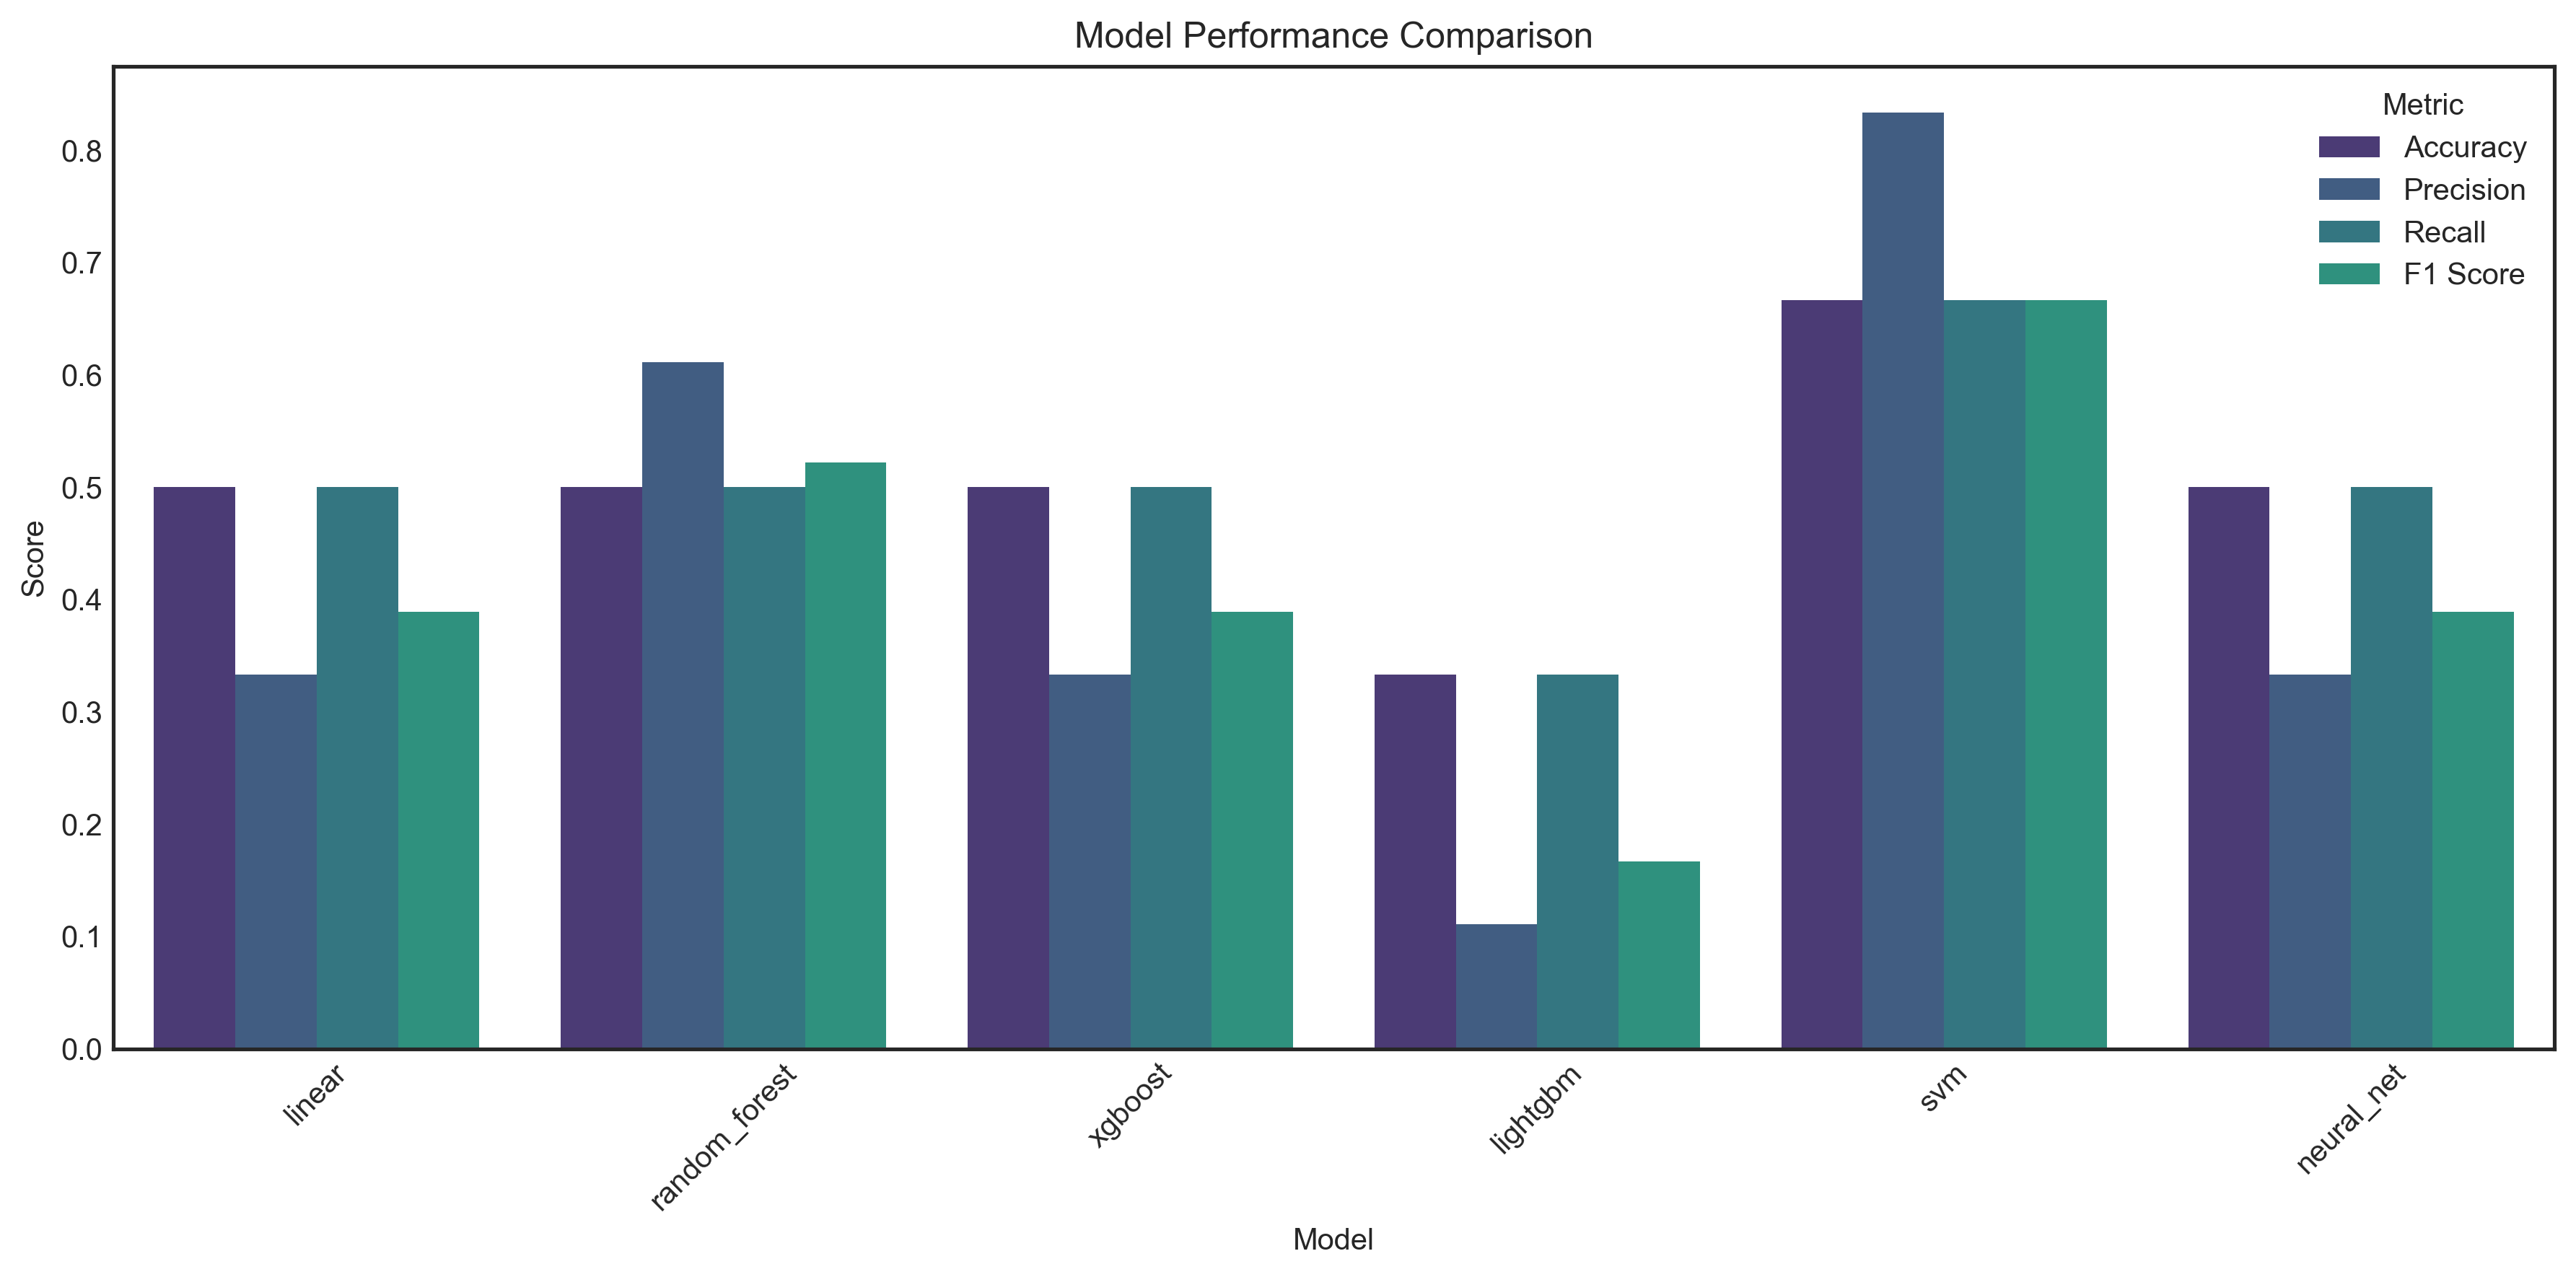

In [6]:
# 1. Model Performance Comparison
import matplotlib.pyplot as plt
import seaborn as sns

def plot_model_comparison(results):
    """Plot comparison of different metrics across models"""
    metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Prepare data for plotting
    plot_data = []
    for model_name, result in results.items():
        if result.get('status') == 'success':
            for metric, metric_name in zip(metrics, metric_names):
                plot_data.append({
                    'Model': model_name,
                    'Metric': metric_name,
                    'Score': result[metric]
                })
    
    # Create grouped bar plot
    df = pd.DataFrame(plot_data)
    sns.barplot(data=df, x='Model', y='Score', hue='Metric')
    plt.xticks(rotation=45)
    plt.title('Model Performance Comparison')
    plt.tight_layout()
    plt.show()

# Call the function
plot_model_comparison(results)

## Interpreting the Confusion Matrices

For each model, the confusion matrix shows:
- True Positives (TP): Correct positive predictions (diagonal)
- False Positives (FP): Incorrect positive predictions (columns)
- False Negatives (FN): Missed positive cases (rows)
- True Negatives (TN): Correct negative predictions

Color intensity indicates:
- Darker colors: Higher number of predictions
- Lighter colors: Fewer predictions

Key insights:
- Strong diagonal: Good overall performance
- Off-diagonal patterns: Systematic misclassifications
- Empty cells: No predictions for that combination

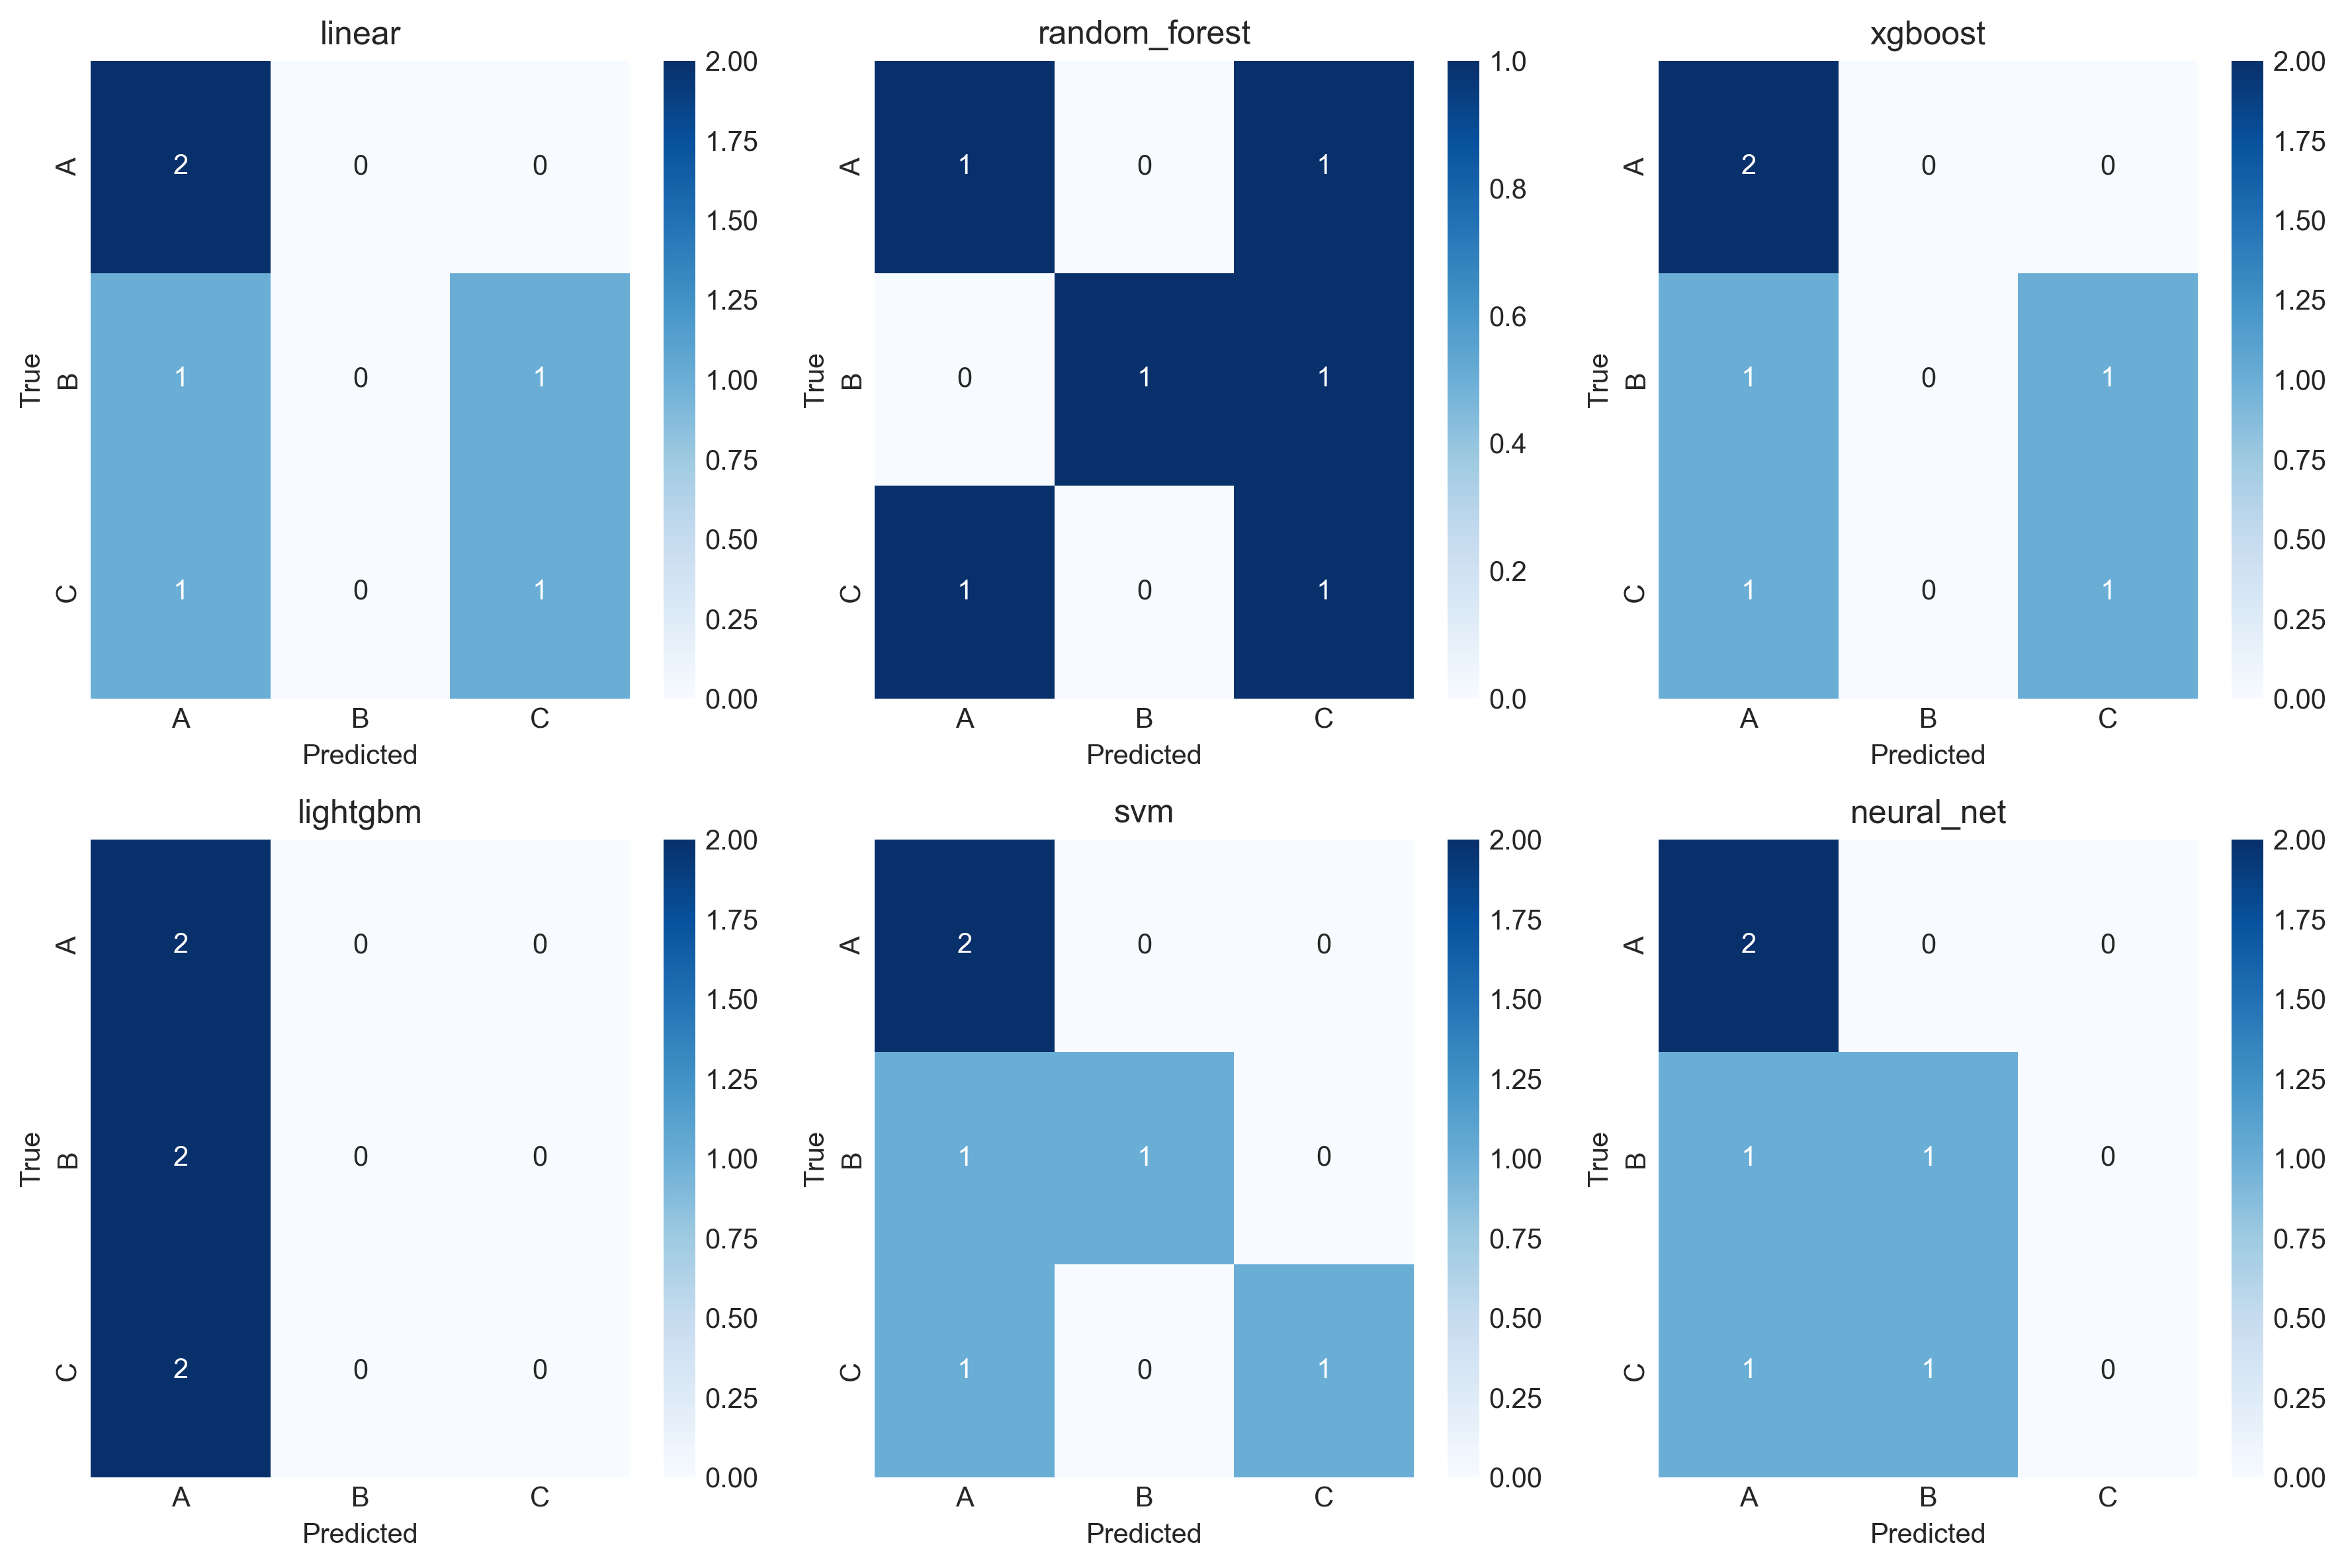

In [7]:
# 2. Confusion Matrices for Each Model
def plot_confusion_matrices(results, y_test):
    """Plot confusion matrices for all models"""
    class_labels = sorted(y_test.unique())
    n_models = len([r for r in results.values() if r.get('status') == 'success'])
    fig_cols = min(3, n_models)
    fig_rows = (n_models - 1) // fig_cols + 1
    
    fig, axes = plt.subplots(fig_rows, fig_cols, 
                             figsize=(4*fig_cols, 4*fig_rows),
                             dpi=config['visualization']['dpi'])
    if fig_rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (model_name, result) in enumerate(results.items()):
        if result.get('status') == 'success':
            row = idx // fig_cols
            col = idx % fig_cols
            
            cm = confusion_matrix(y_test, result['y_test_pred'], labels=class_labels)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=class_labels, yticklabels=class_labels,
                        ax=axes[row, col])
            axes[row, col].set_title(f'{model_name}')
            axes[row, col].set_xlabel('Predicted')
            axes[row, col].set_ylabel('True')
    
    # Remove empty subplots
    for idx in range(n_models, fig_rows * fig_cols):
        row = idx // fig_cols
        col = idx % fig_cols
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_confusion_matrices(results, y_test)

For each model, the confusion matrix shows:
- True Positives (TP): Correct positive predictions (diagonal)
- False Positives (FP): Incorrect positive predictions (columns)
- False Negatives (FN): Missed positive cases (rows)
- True Negatives (TN): Correct negative predictions

Color intensity indicates:
- Darker colors: Higher number of predictions
- Lighter colors: Fewer predictions

Key insights:
- Strong diagonal: Good overall performance
- Off-diagonal patterns: Systematic misclassifications
- Empty cells: No predictions for that combination

## Feature Importance Analysis

Visualize which features contribute most to model predictions. This analysis is available for tree-based models (Random Forest, XGBoost, LightGBM) that provide feature importance scores.

The feature importance plot shows:
- Top 10 most influential features
- Relative importance scores (0-1 scale)
- Comparison across different models

Interpretation:
- Higher scores indicate stronger influence on predictions
- Different models may rank features differently
- Features not shown have lower importance scores

Note: Feature importance methods vary by model type:
- Random Forest: Mean decrease in impurity
- XGBoost/LightGBM: Gain-based importance

random_forest feature importances: [0.11316634 0.10566452 0.09443502 0.07657559 0.11964797]
xgboost feature importances: [0.09391747 0.12233187 0.09713509 0.0918909  0.10527088]
lightgbm feature importances: [0 0 0 0 0]


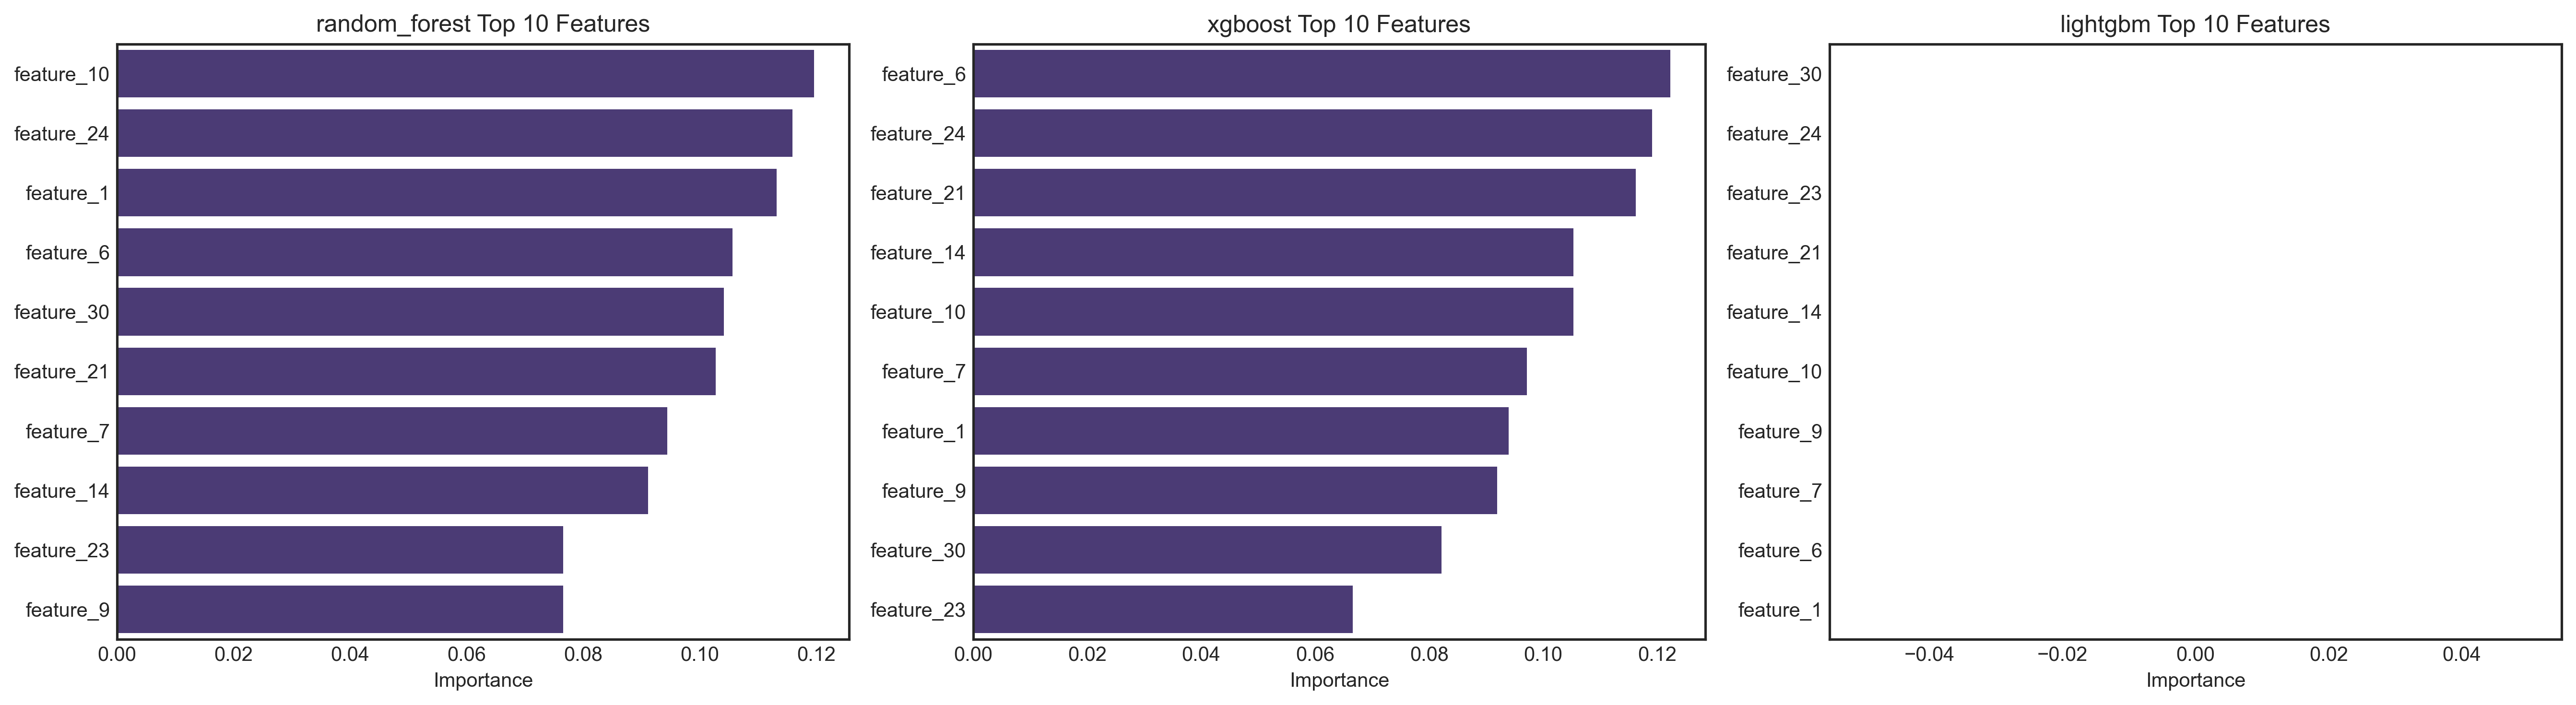

In [8]:
# 3. Feature Importance Plot (for supported models)
def plot_feature_importance(results, feature_names):
    """Plot feature importance for models that support it"""
    supported_models = {
        name: result for name, result in results.items()
        if (result.get('status') == 'success' and 
            hasattr(result['model'], 'feature_importances_'))
    }
    
    if not supported_models:
        print("No models with feature importance found.")
        return
    
    n_models = len(supported_models)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
    if n_models == 1:
        axes = [axes]
    
    for ax, (name, result) in zip(axes, supported_models.items()):
        importances = result['model'].feature_importances_
        print(f"{name} feature importances: {importances[:5]}")
        indices = np.argsort(importances)[::-1]
        
        sns.barplot(x=importances[indices][:10], 
                   y=[feature_names[i] for i in indices][:10],
                   ax=ax)
        ax.set_title(f'{name} Top 10 Features')
        ax.set_xlabel('Importance')
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_feature_importance(results, selected_features)

The bar plots reveal:
- Which features drive model decisions
- Relative strength of feature contributions
- Potential feature redundancy
- Opportunities for feature selection refinement

This information helps:
- Validate feature selection decisions
- Guide feature engineering efforts
- Understand model behavior
- Identify potential data quality issues

## Cross-validation Score Distribution

Visualize the distribution of cross-validation scores across different models using box plots. This helps assess both model performance and stability.

The box plot shows for each model:
- Median performance (center line)
- Interquartile range (box)
- Score spread (whiskers)
- Potential outliers (points)

Key insights:
- Higher median = better overall performance
- Smaller box = more stable performance
- Wide spread = high sensitivity to data splits
- Overlapping boxes = statistically similar models

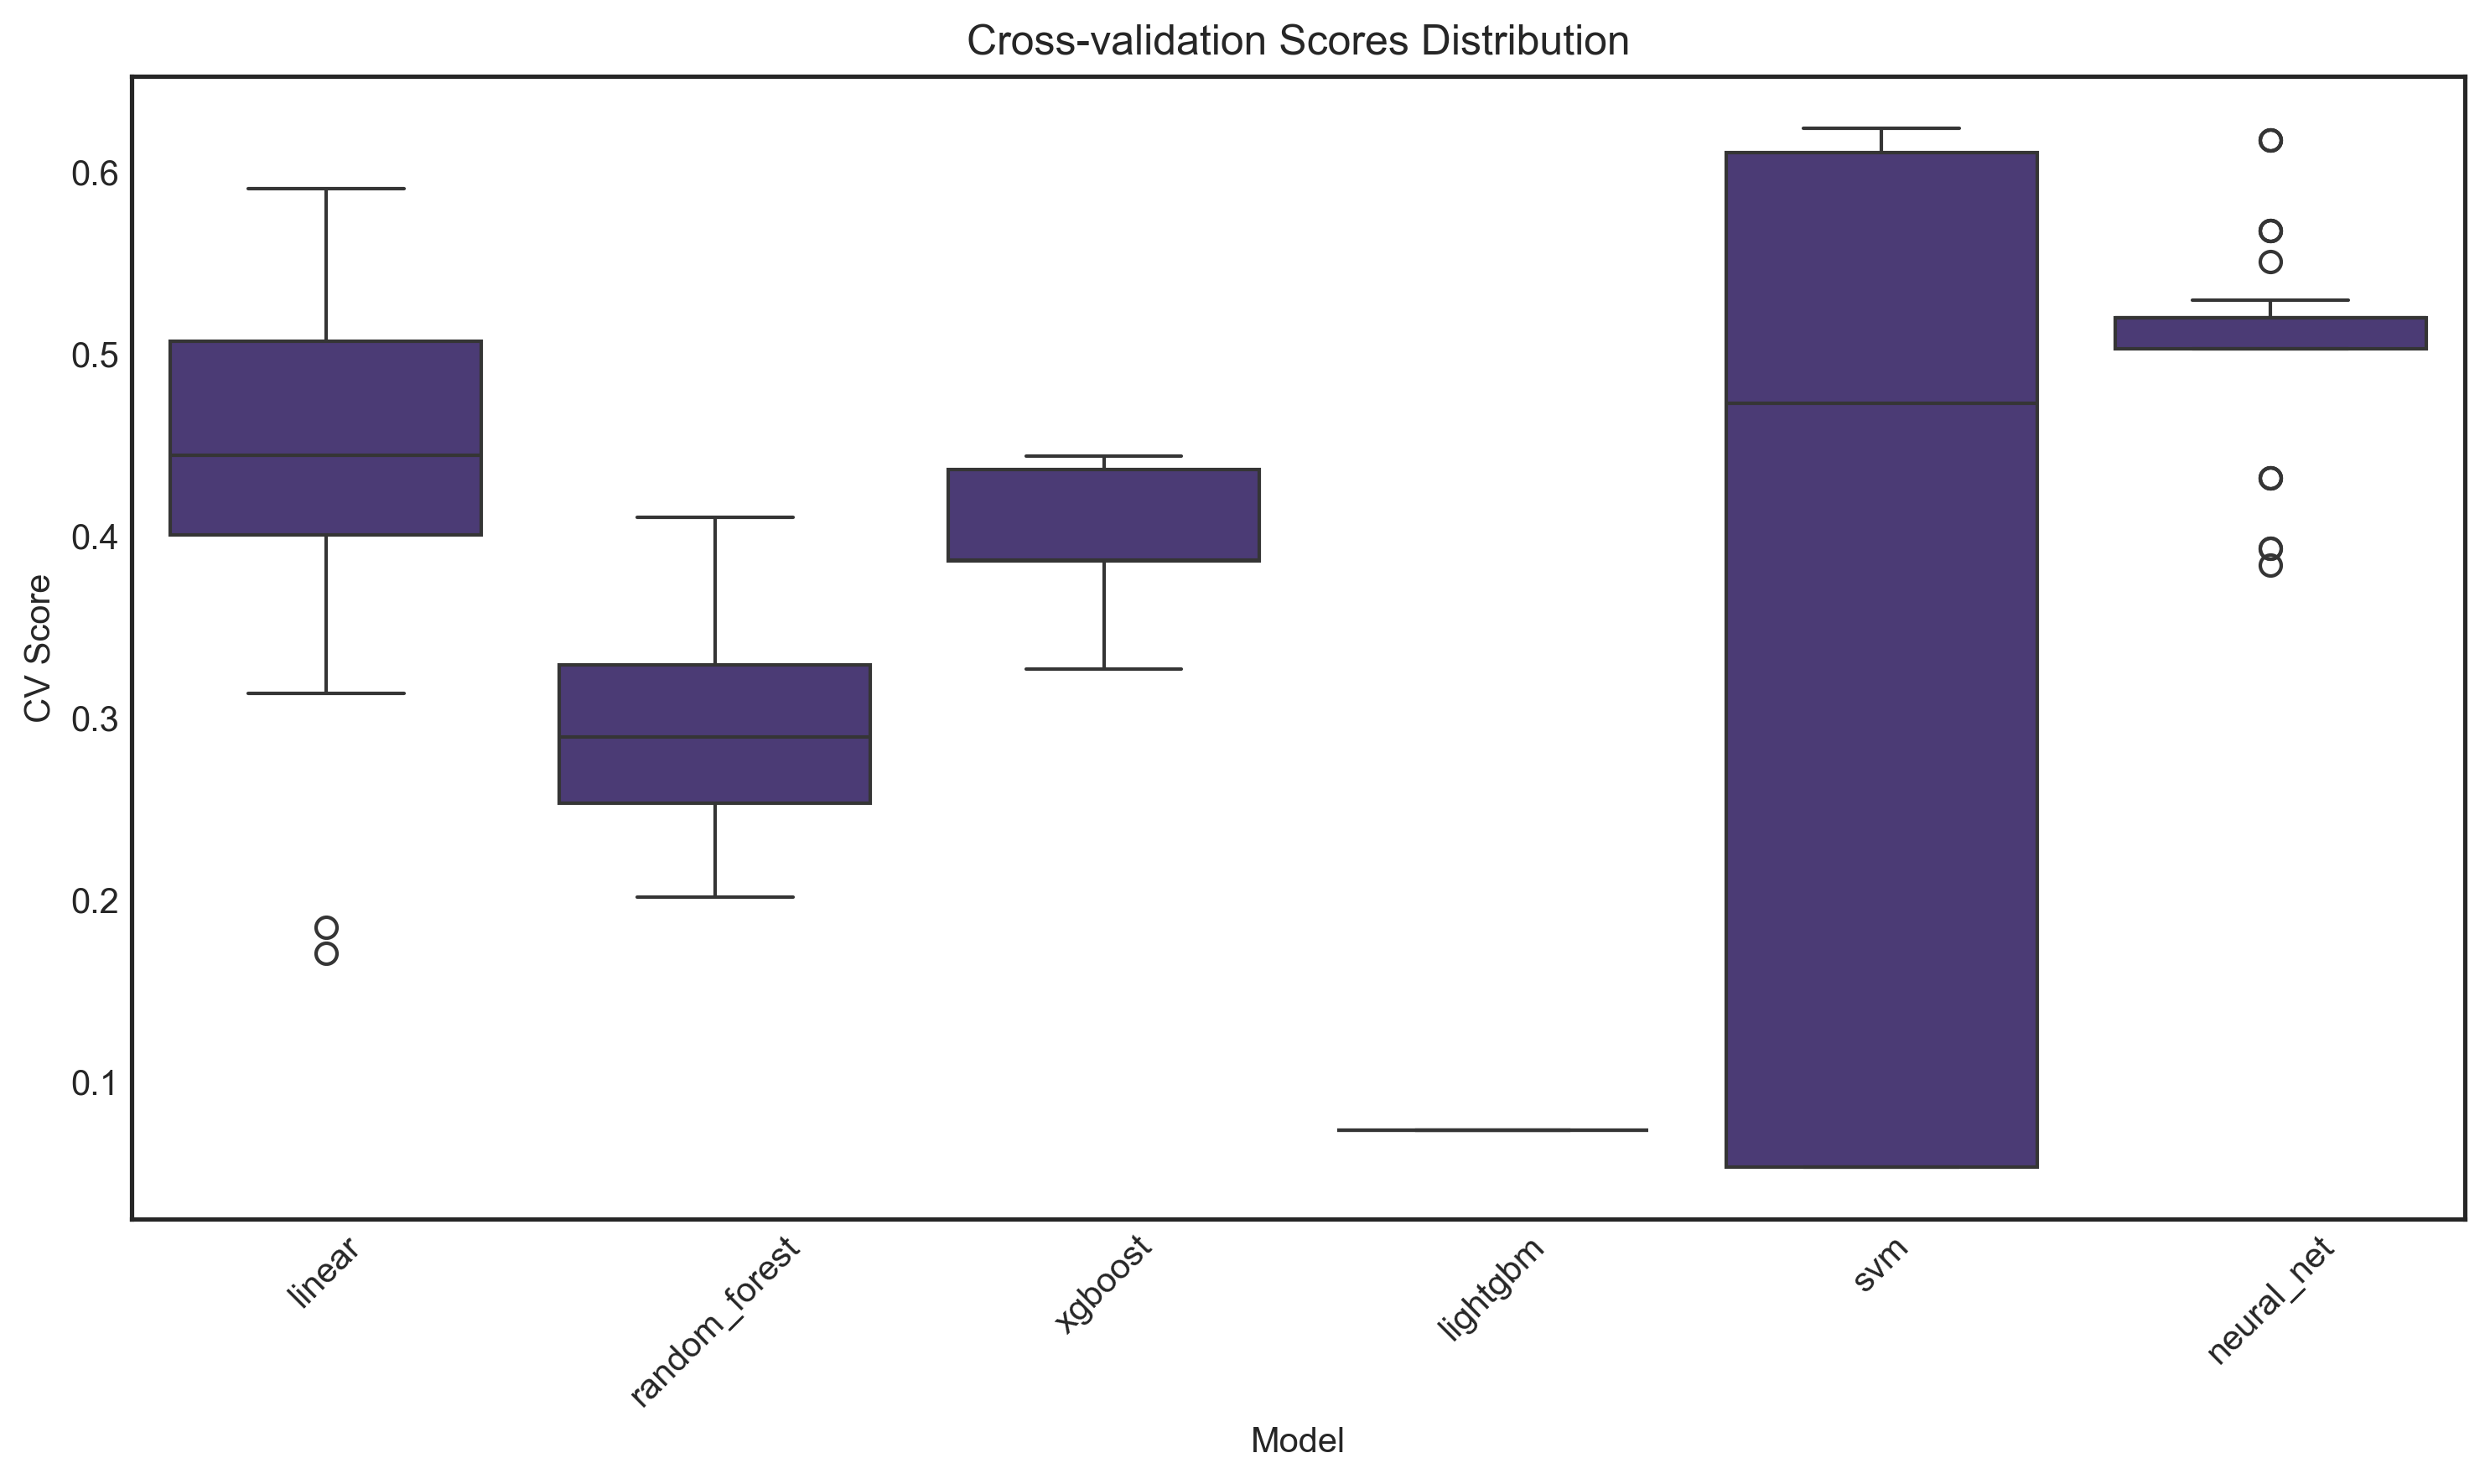

In [9]:
# 4. Cross-validation Scores Distribution
def plot_cv_scores_distribution(results):
    """Plot distribution of cross-validation scores"""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    cv_scores = []
    model_names = []
    
    for model_name, result in results.items():
        if result.get('status') == 'success':
            scores = result['cv_results']['mean_test_score']
            cv_scores.extend(scores)
            model_names.extend([model_name] * len(scores))
    
    sns.boxplot(x=model_names, y=cv_scores)
    plt.xticks(rotation=45)
    plt.title('Cross-validation Scores Distribution')
    plt.xlabel('Model')
    plt.ylabel('CV Score')
    plt.tight_layout()
    plt.show()

# Call the function
plot_cv_scores_distribution(results)

The visualization helps us understand:
- Which models perform most consistently
- Performance variability across data splits
- Potential overfitting (high variance)
- Relative model stability

This information guides:
- Model selection decisions
- Reliability assessment
- Potential ensemble strategies
- Performance expectations in production

## Prediction Confidence Analysis

Examine how confident each model is in its predictions by comparing probability distributions between correct and incorrect predictions. This analysis helps understand model reliability and potential calibration needs.

The histograms show:
- Distribution of prediction probabilities
- Separate views for correct vs. incorrect predictions
- Confidence patterns for each model
- Potential overconfidence or uncertainty

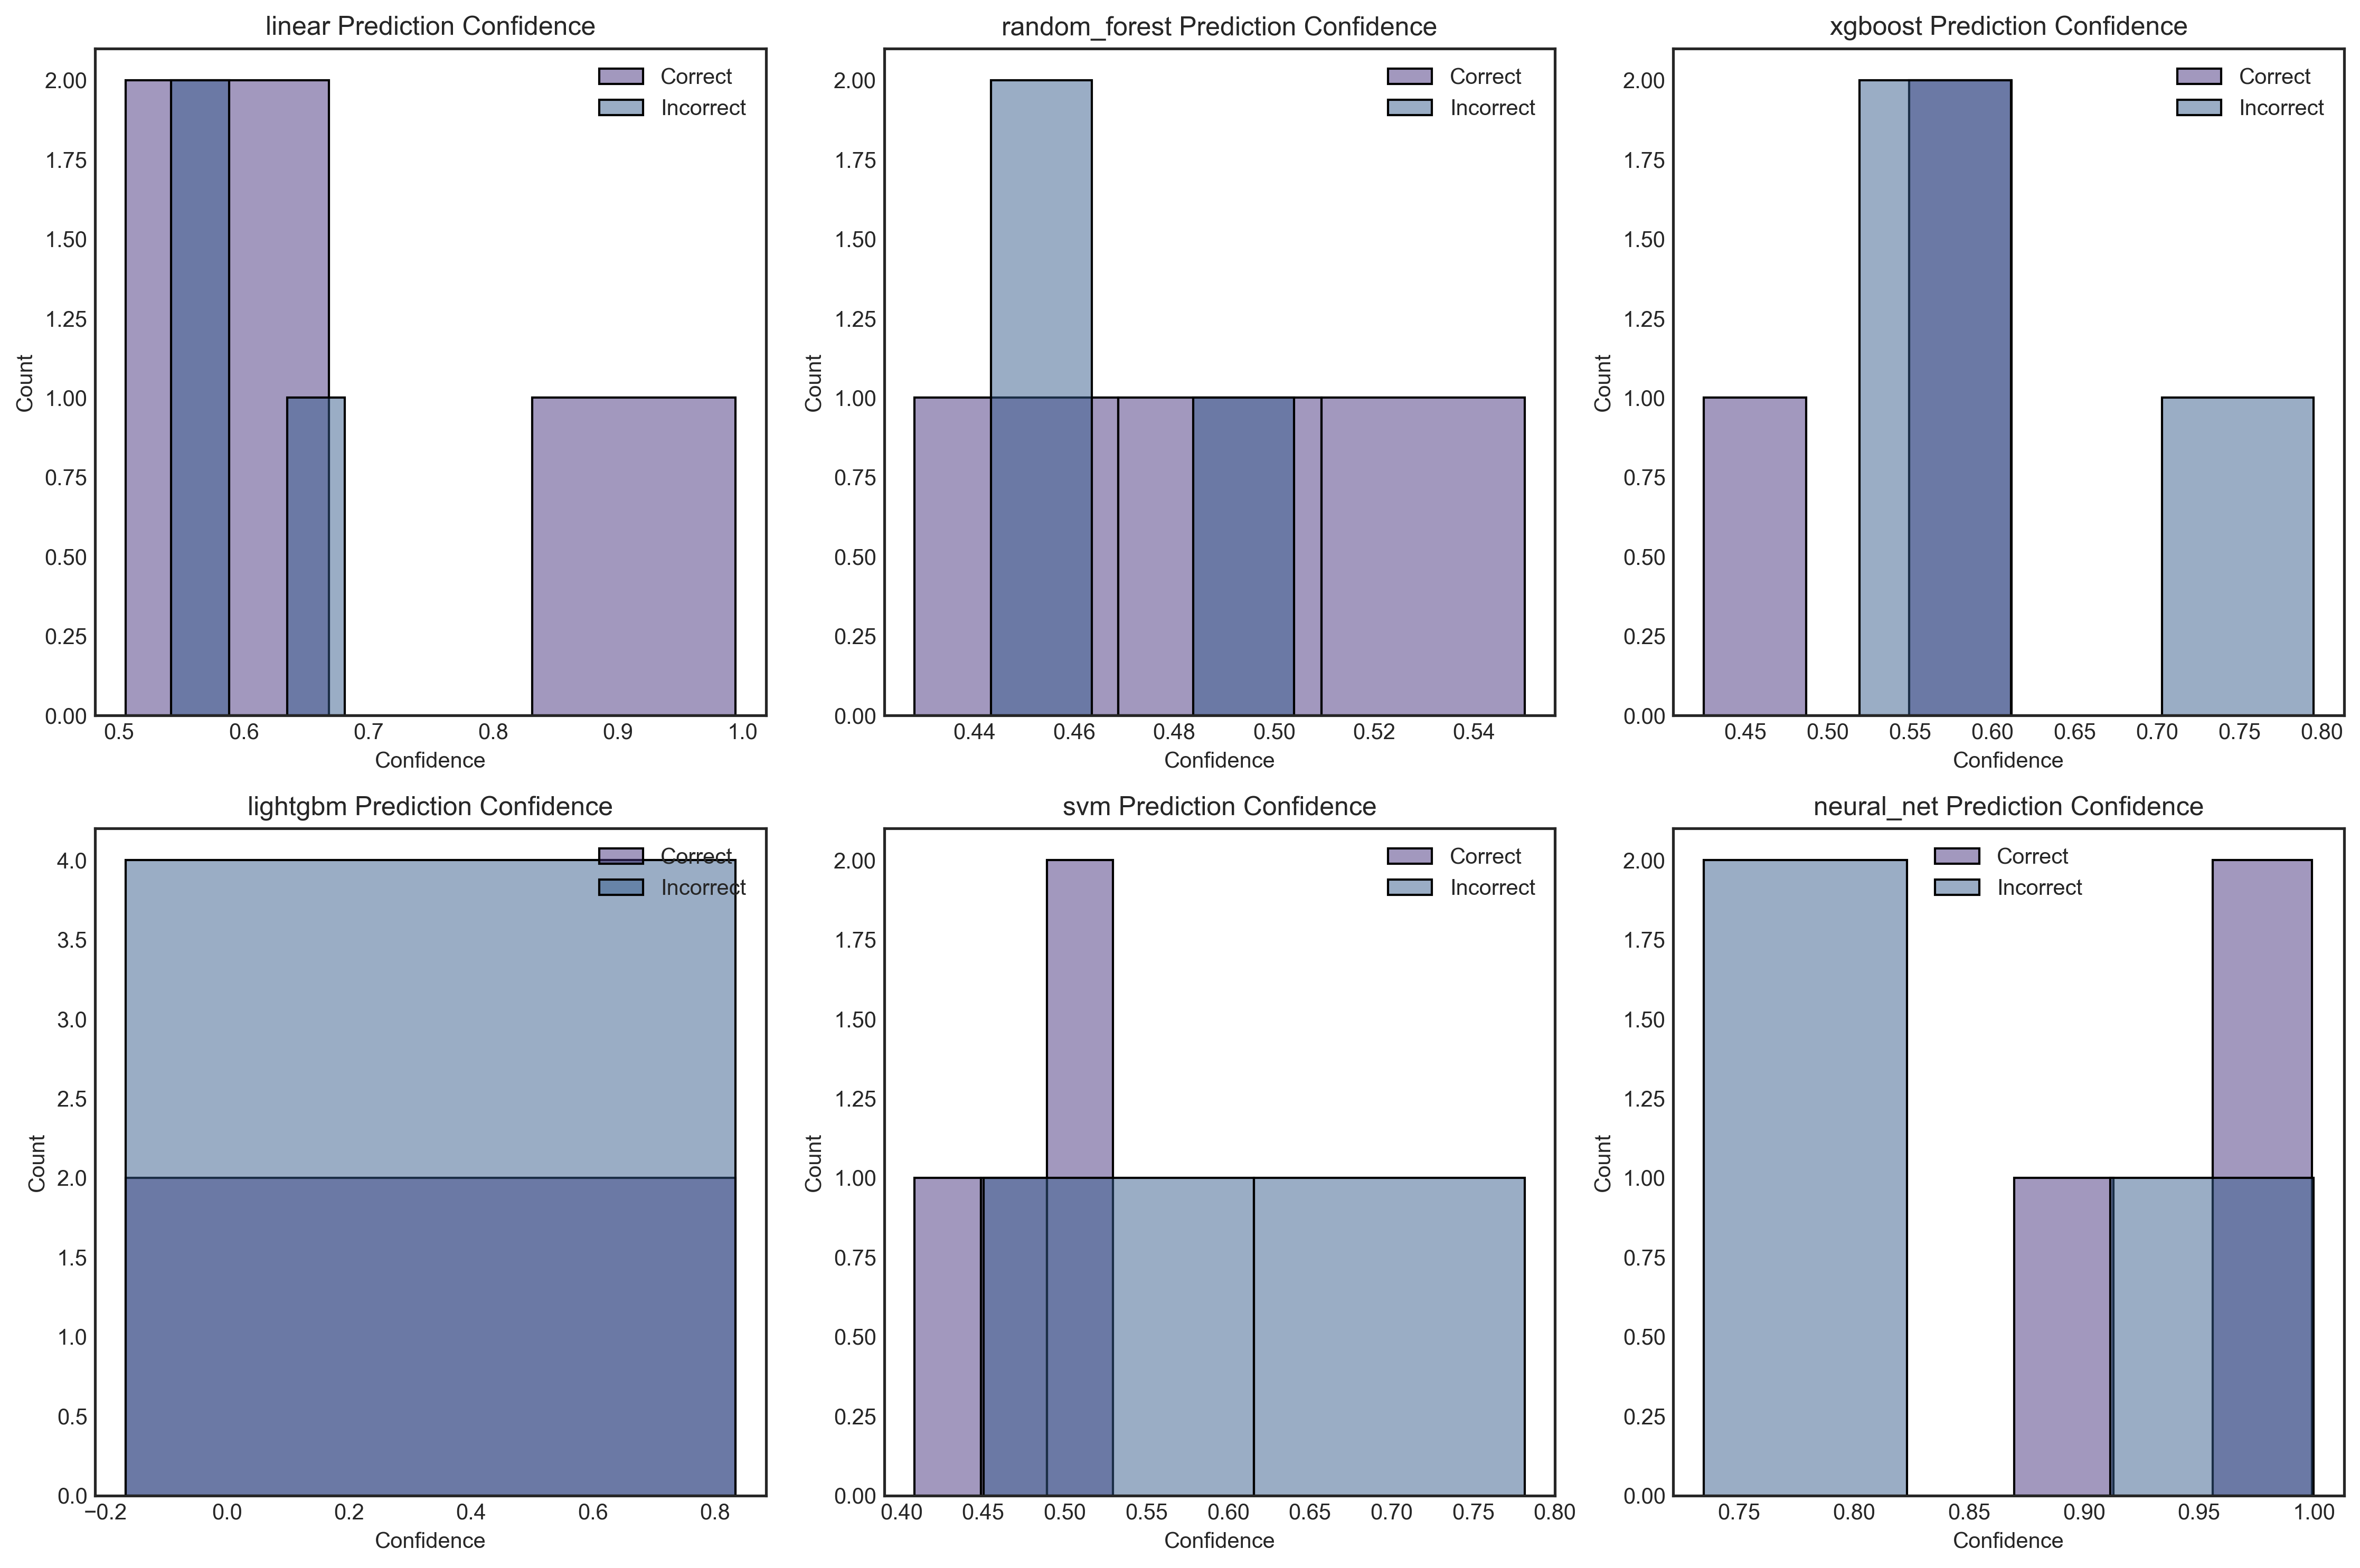

In [10]:
# 5. Prediction Confidence Analysis
def plot_prediction_confidence(results, y_test):
    """Plot prediction confidence distribution for correct vs incorrect predictions"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, (model_name, result) in enumerate(results.items()):
        if (result.get('status') == 'success' and 
            hasattr(result['model'], 'predict_proba')):
            
            # Get prediction probabilities
            y_pred_proba = result['model'].predict_proba(X_test)
            confidence = np.max(y_pred_proba, axis=1)
            
            # Separate correct and incorrect predictions
            correct = result['y_test_pred'] == y_test
            
            # Plot distributions
            sns.histplot(data=confidence[correct], 
                        label='Correct', alpha=0.5, ax=axes[idx])
            sns.histplot(data=confidence[~correct], 
                        label='Incorrect', alpha=0.5, ax=axes[idx])
            
            axes[idx].set_title(f'{model_name} Prediction Confidence')
            axes[idx].set_xlabel('Confidence')
            axes[idx].set_ylabel('Count')
            axes[idx].legend()
    
    # Remove empty subplots
    for idx in range(len(results), 6):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_prediction_confidence(results, y_test)

For each model, we can observe:
- Ideal pattern: High confidence for correct predictions, low confidence for incorrect ones
- Overconfidence: High confidence even for wrong predictions
- Uncertainty: Low confidence even for correct predictions

Key insights:
- Well-calibrated models: Clear separation between correct and incorrect confidence distributions
- Overconfident models: High confidence peaks for both distributions
- Uncertain models: Overlapping distributions with lower confidence

This information helps:
- Set appropriate confidence thresholds
- Identify need for model calibration
- Understand prediction reliability
- Guide deployment decisions

## Learning Curves Analysis

Learning curves show how model performance changes with increasing training data. This helps diagnose overfitting, underfitting, and whether more data would help improve performance.

The plots show for each model:
- Training score (blue line)
- Cross-validation score (orange line)
- Score variability (shaded regions)
- Performance across different training set sizes

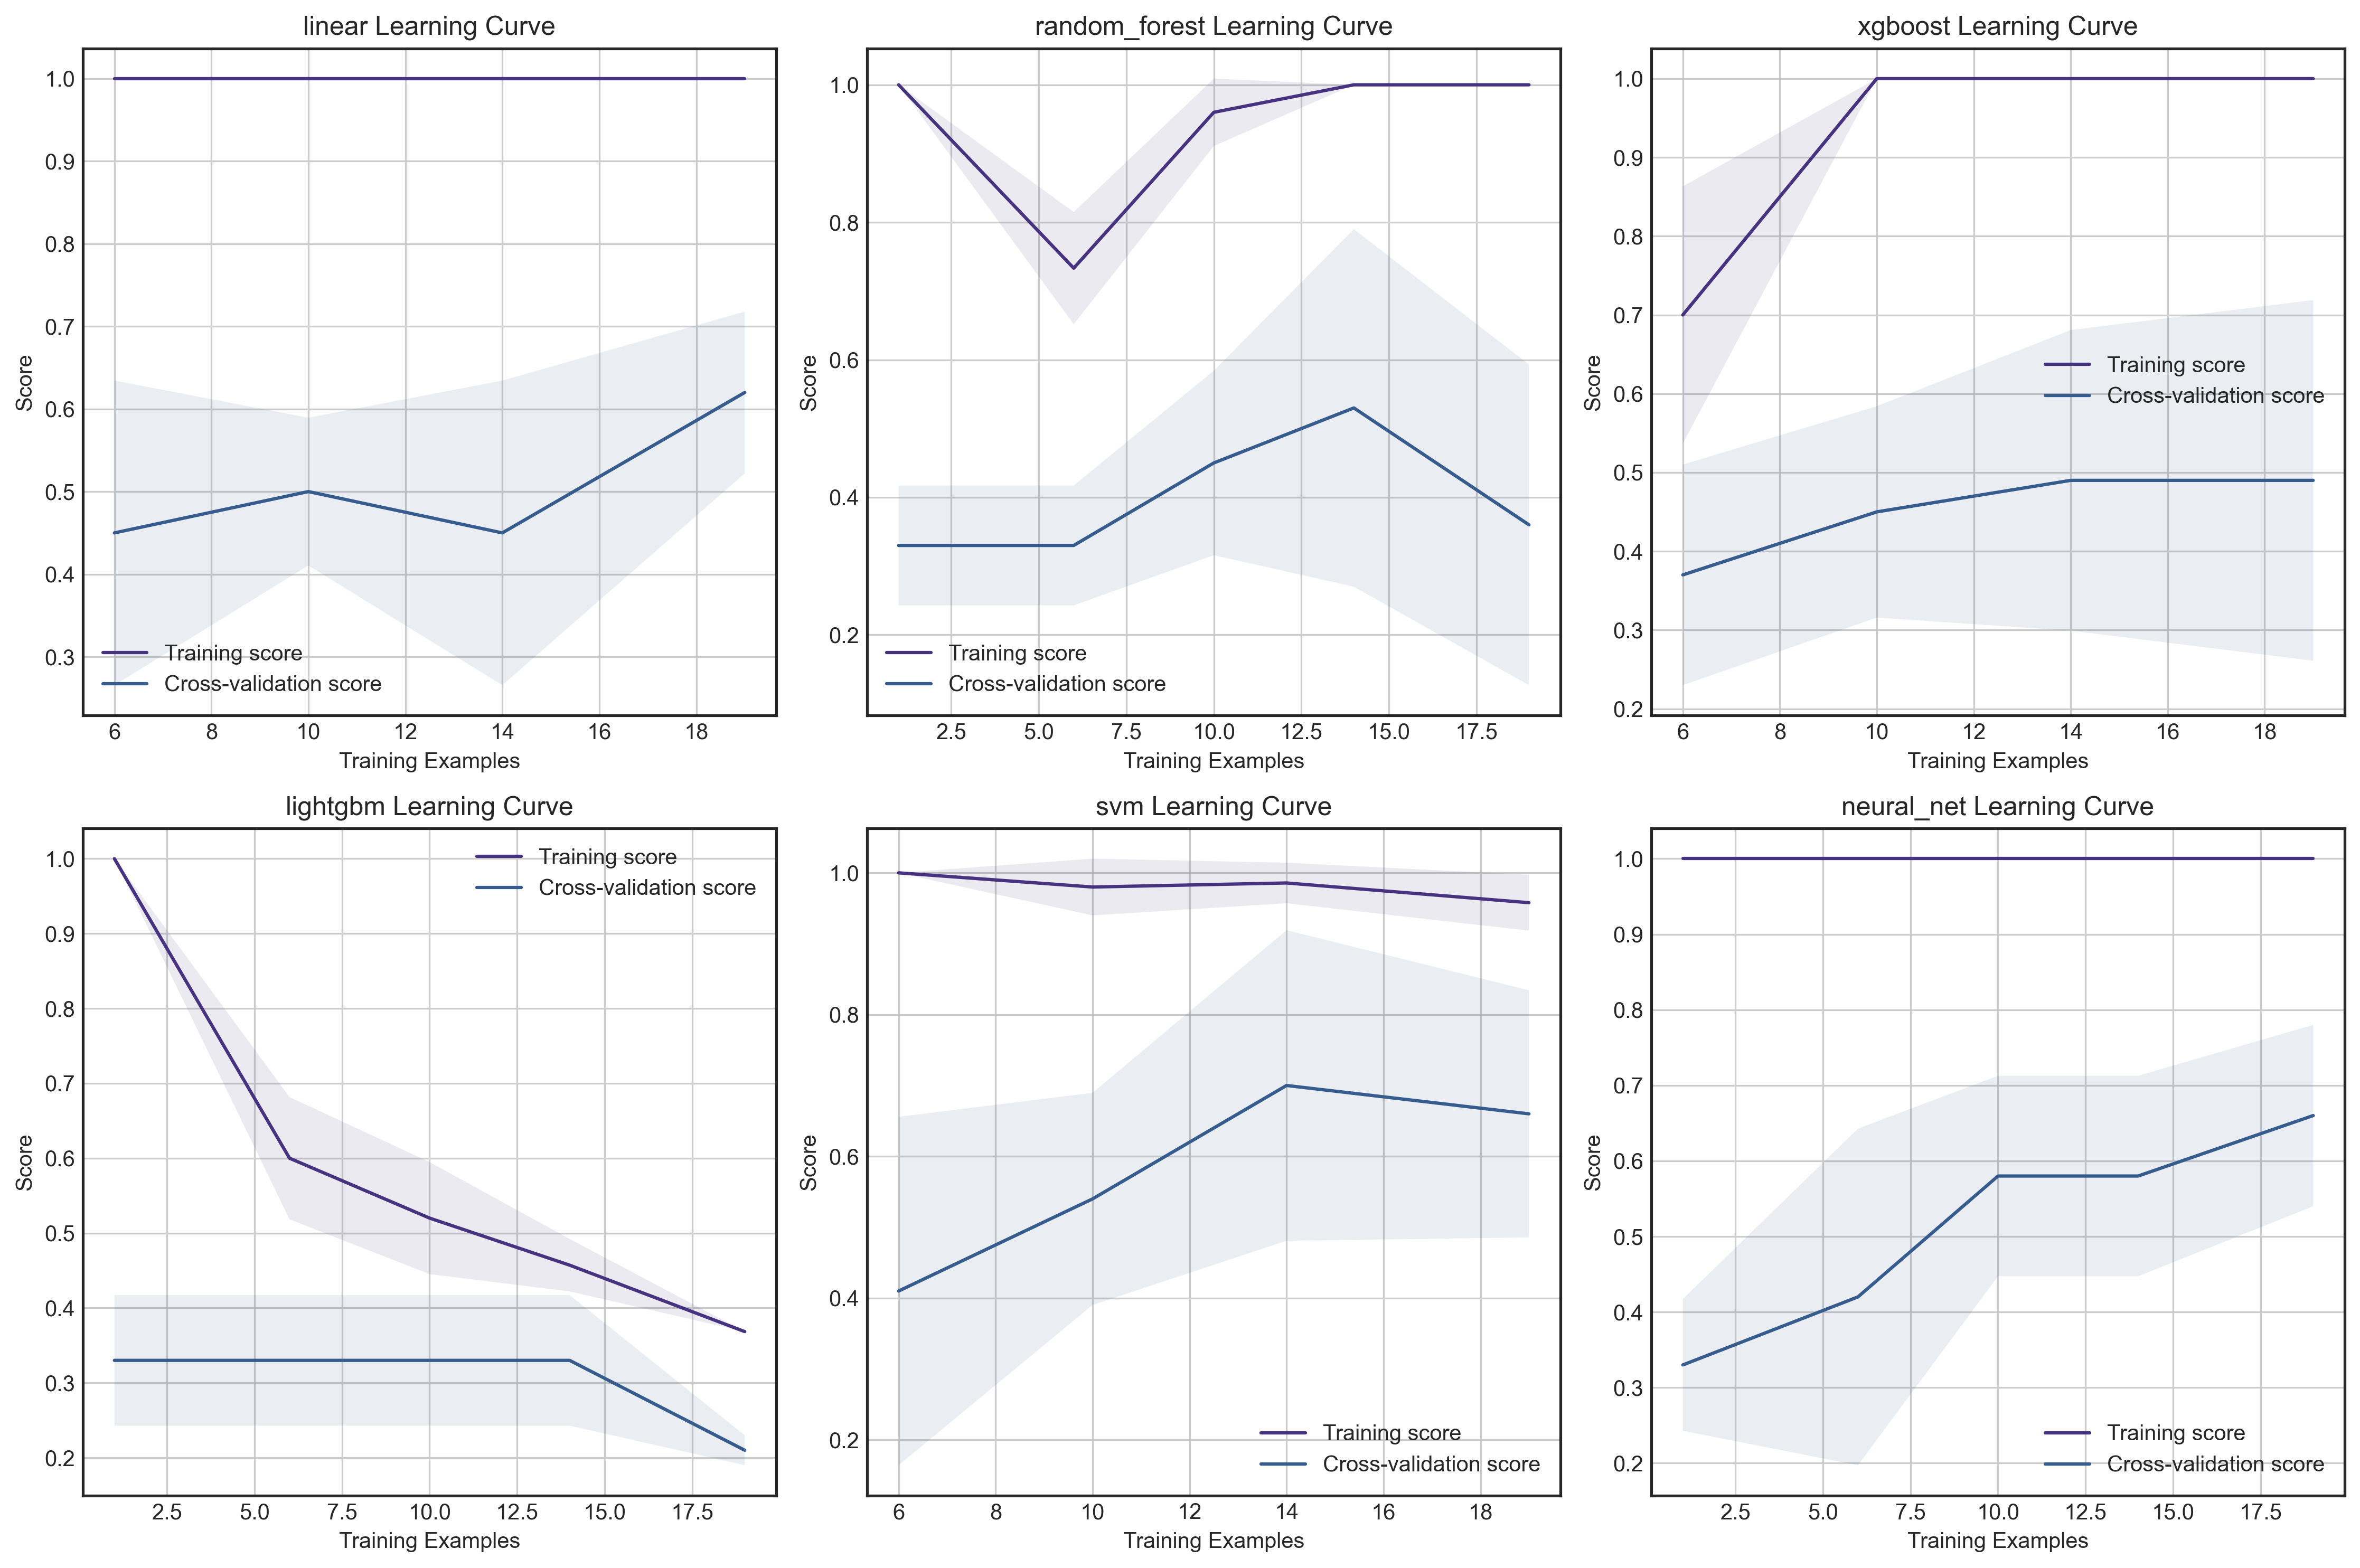

In [11]:
# 6. Learning Curves
from sklearn.model_selection import learning_curve

def plot_learning_curves(results, X_train, y_train):
    """Plot learning curves for all models"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    train_sizes = np.linspace(0.1, 1.0, 5)
    
    for idx, (model_name, result) in enumerate(results.items()):
        if result.get('status') == 'success':
            train_sizes_abs, train_scores, val_scores = learning_curve(
                result['model'], X_train, y_train,
                train_sizes=train_sizes,
                cv=5, n_jobs=-1)
            
            train_mean = np.mean(train_scores, axis=1)
            train_std = np.std(train_scores, axis=1)
            val_mean = np.mean(val_scores, axis=1)
            val_std = np.std(val_scores, axis=1)
            
            axes[idx].plot(train_sizes_abs, train_mean, 
                          label='Training score')
            axes[idx].fill_between(train_sizes_abs, 
                                 train_mean - train_std,
                                 train_mean + train_std, alpha=0.1)
            axes[idx].plot(train_sizes_abs, val_mean, 
                          label='Cross-validation score')
            axes[idx].fill_between(train_sizes_abs,
                                 val_mean - val_std,
                                 val_mean + val_std, alpha=0.1)
            
            axes[idx].set_title(f'{model_name} Learning Curve')
            axes[idx].set_xlabel('Training Examples')
            axes[idx].set_ylabel('Score')
            axes[idx].legend(loc='best')
            axes[idx].grid(True)
    
    # Remove empty subplots
    for idx in range(len(results), 6):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_learning_curves(results, X_train_balanced, y_train_encoded)

Common patterns and their meanings:

1. Convergence Gap:
   - Small gap: Good fit
   - Large gap: Overfitting
   - No gap but low scores: Underfitting

2. Score Trends:
   - Both curves plateau: More data won't help
   - Curves still rising: More data might help
   - High variance in shaded areas: Unstable performance

3. Training Size Impact:
   - Rapid initial improvement: Model learns key patterns quickly
   - Slow, steady improvement: Complex patterns require more data
   - Early plateau: Model reaches capacity quickly

This visualization helps:
- Determine if more training data would help
- Identify overfitting/underfitting
- Compare model learning efficiency
- Guide data collection efforts

## ROC Curve Visualization

Visualize model performance using ROC curves:
- Plot test set performance for each model
- Show micro-averaged ROC for multiclass problems
- Display individual class performance when applicable
- Include cross-validation scores for context

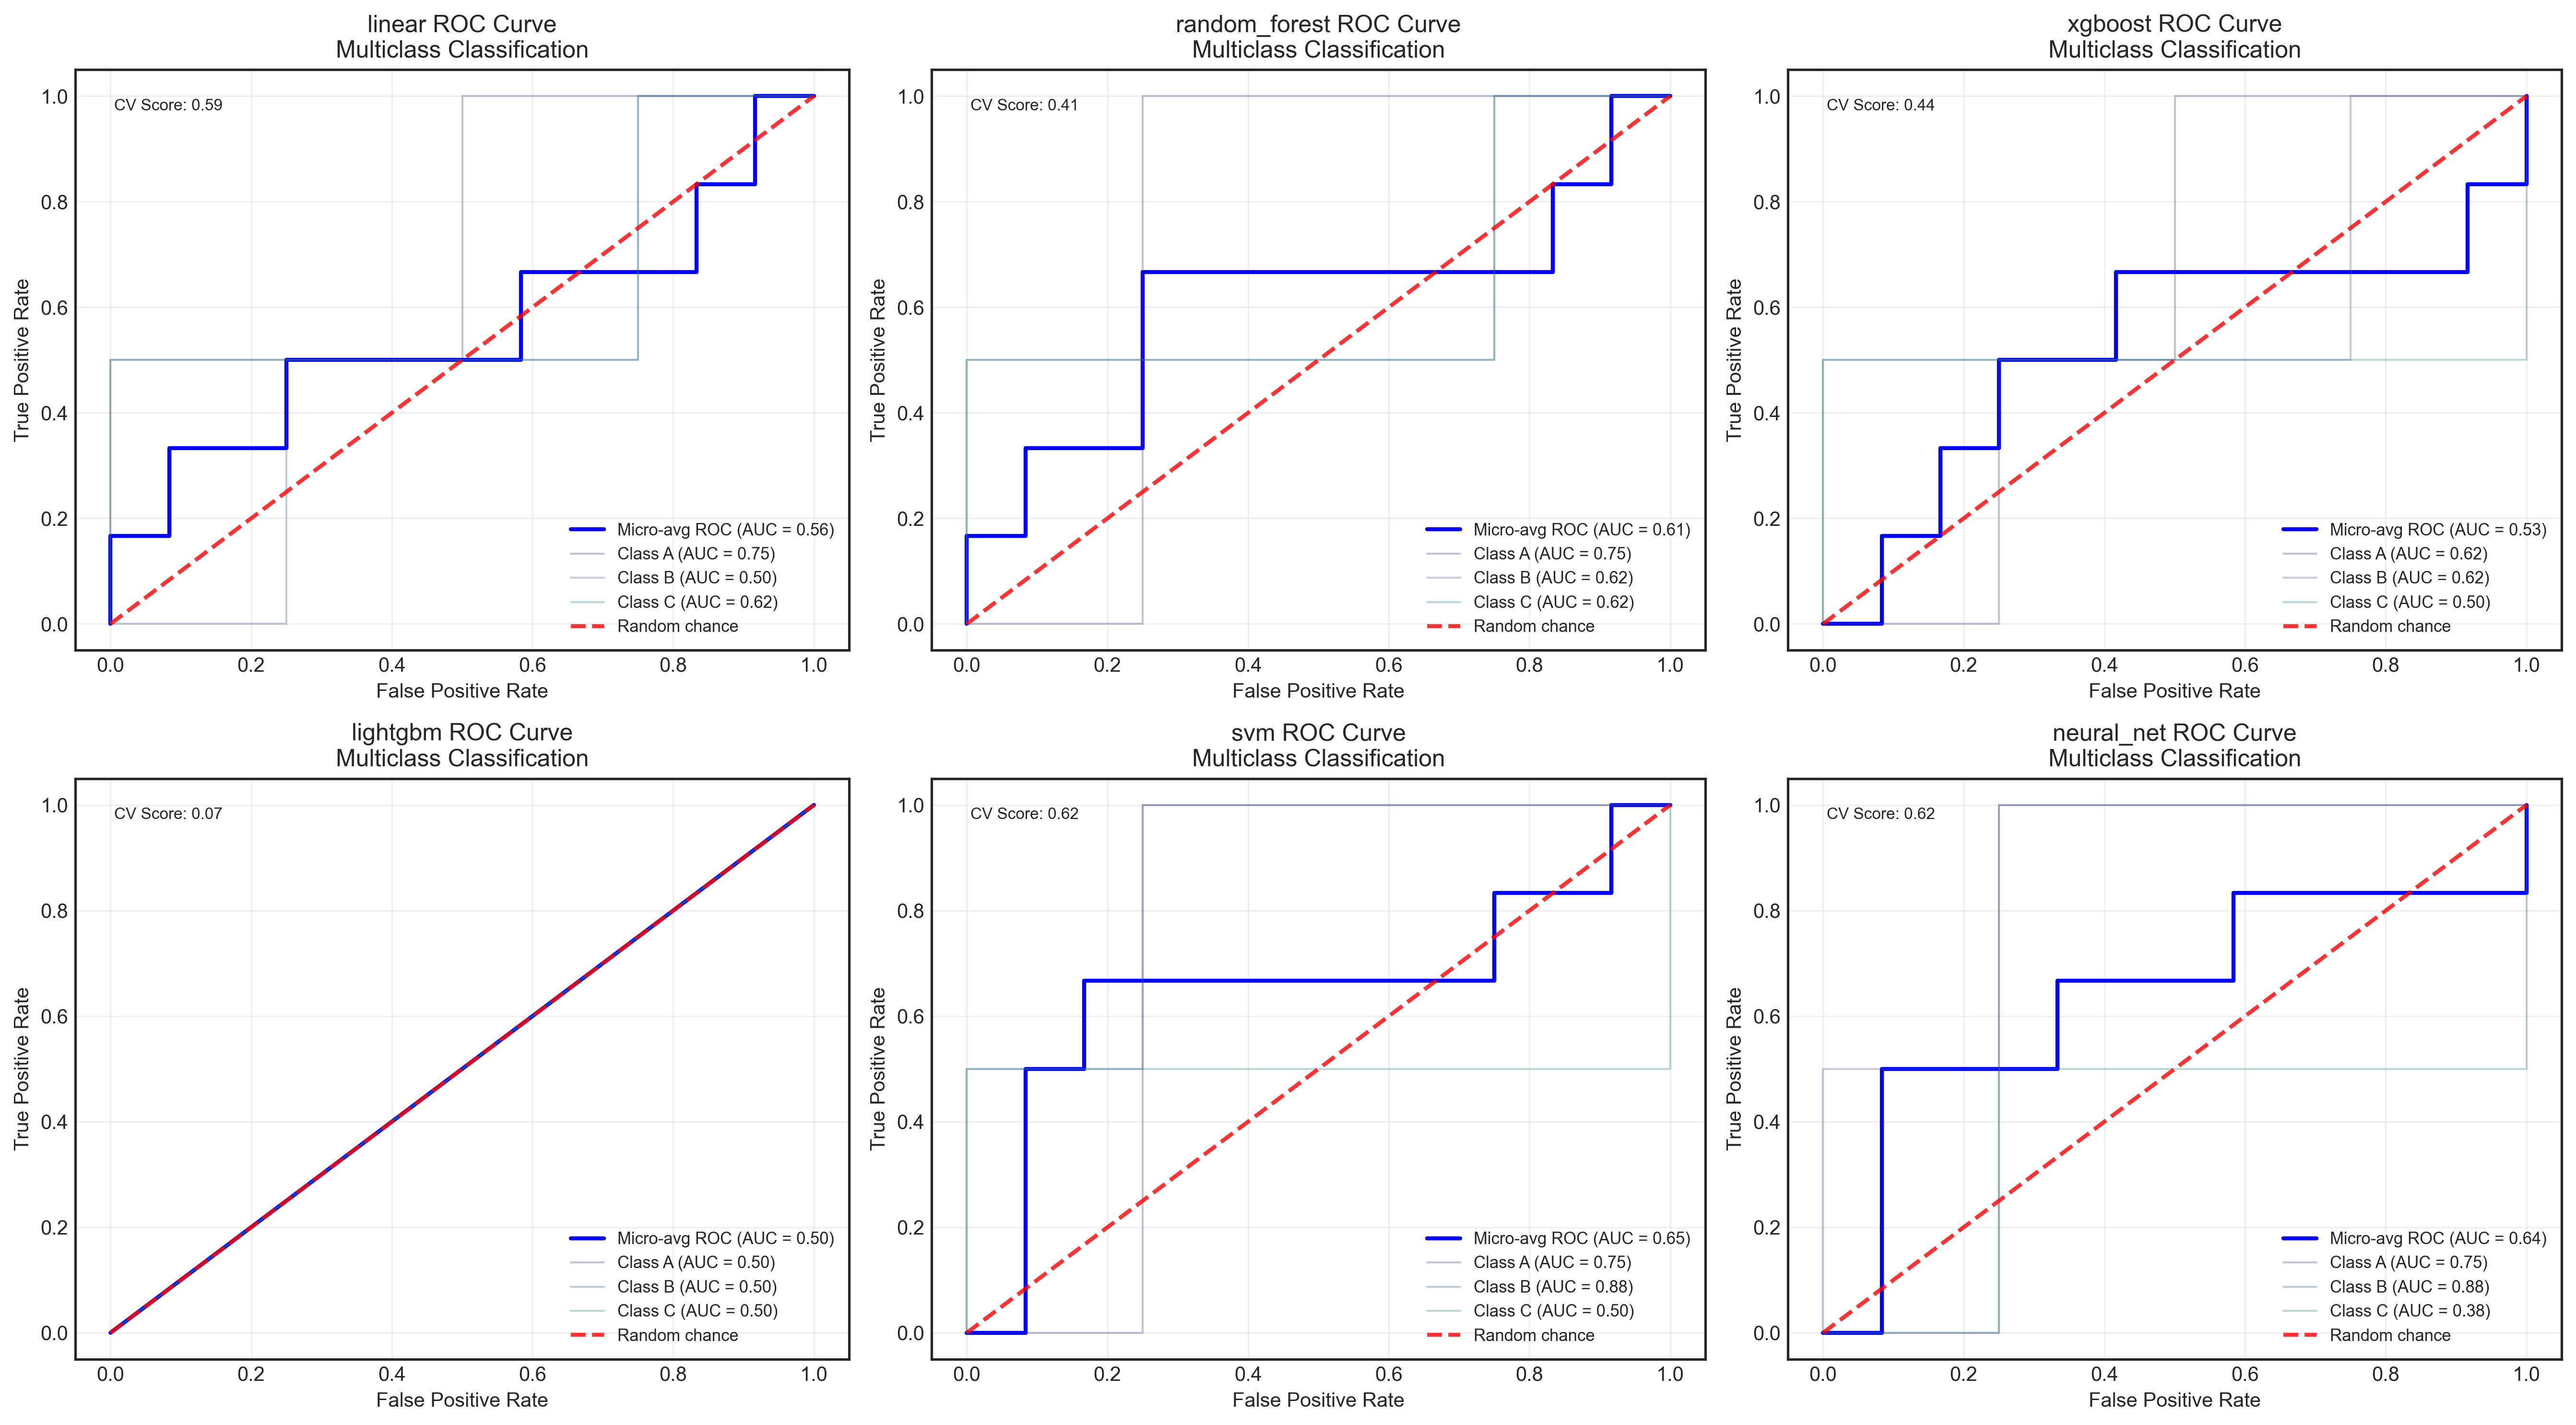

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_roc_curves(results, X_test, y_test):
    """
    Plot ROC curves using the best models from cross-validation.
    Uses test set for final evaluation.
    
    Args:
        results: Dictionary containing trained models and their results
        X_test: Test features
        y_test: Test labels
    """
    
    # Get unique classes
    classes = np.unique(y_test)
    n_classes = len(classes)
    
    # Calculate number of rows and columns for subplots
    n_models = len([r for r in results.values() if r.get('status') == 'success'])
    n_cols = min(3, n_models)
    n_rows = (n_models - 1) // n_cols + 1
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes = axes.ravel()
    
    for idx, (model_name, result) in enumerate(results.items()):
        if result.get('status') != 'success':
            continue
            
        ax = axes[idx]
        model = result['model']
        
        if n_classes == 2:
            # Binary classification
            y_score = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            
            # Plot ROC curve
            ax.plot(fpr, tpr, color='b',
                   label=f'ROC (AUC = {roc_auc:.2f})',
                   lw=2)
            
        else:
            # Multiclass classification
            y_test_bin = label_binarize(y_test, classes=classes)
            y_score = model.predict_proba(X_test)
            
            # Compute micro-average ROC curve and AUC
            fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
            roc_auc = auc(fpr, tpr)
            
            # Plot ROC curve
            ax.plot(fpr, tpr, color='b',
                   label=f'Micro-avg ROC (AUC = {roc_auc:.2f})',
                   lw=2)
            
            # Optional: Plot ROC curves for each class
            for i in range(n_classes):
                fpr_class, tpr_class, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
                auc_class = auc(fpr_class, tpr_class)
                ax.plot(fpr_class, tpr_class, lw=1, alpha=0.3,
                       label=f'Class {classes[i]} (AUC = {auc_class:.2f})')
        
        # Plot random chance line
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                alpha=.8, label='Random chance')
        
        # Add CV score information if available
        if 'best_score' in result:
            cv_text = f'CV Score: {result["best_score"]:.2f}'
            if 'cv_results_' in result and 'mean_test_score' in result['cv_results_']:
                cv_std = np.std(result['cv_results_']['mean_test_score'])
                cv_text += f' ± {cv_std:.2f}'
            ax.text(0.05, 0.95, cv_text,
                   transform=ax.transAxes, fontsize=8,
                   verticalalignment='top')
        
        # Customize plot
        ax.set_title(f'{model_name} ROC Curve\n{"Binary" if n_classes == 2 else "Multiclass"} Classification')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower right', fontsize='small')
        ax.grid(True, alpha=0.3)
    
    # Remove empty subplots
    for idx in range(n_models, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()

# Call the function with test data
plot_roc_curves(results, X_test, y_test)

The visualization helps us understand:
- Which models perform best for our specific task
- How well models generalize to unseen data
- Any class-specific performance patterns
- Stability of model performance across CV folds

In [13]:
import pickle
from pathlib import Path
import datetime
import json

# Create directory if it doesn't exist
save_dir = Path('../data/processed')
save_dir.mkdir(parents=True, exist_ok=True)

# Timestamp for versioning
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Collect objects to save (keep your existing structure)
training_artifacts = {
    'models': {
        name: result['model'] 
        for name, result in results.items() 
        if result.get('status') == 'success'
    },
    'performance_metrics': {
        name: {
            'test_accuracy': result['test_accuracy'],
            'test_precision': result['test_precision'],
            'test_recall': result['test_recall'],
            'test_f1': result['test_f1'],
            'cv_score': result['best_score'],
            'best_params': result['best_params']
        }
        for name, result in results.items()
        if result.get('status') == 'success'
    },
    'feature_info': {
        'feature_names': selected_features,
        'n_features': len(selected_features)
    },
    'label_info': {
        'label_encoder': factory.label_encoder if hasattr(factory, 'label_encoder') else None,
        'classes': np.unique(y_train_balanced),
        'classification_type': classification_type,
        'n_classes': n_classes
    },
    'training_config': {
        'model_configs': {
            name: result['best_params']
            for name, result in results.items()
            if result.get('status') == 'success'
        },
        'original_config': config
    },
    'data_info': {
        'n_train_samples': len(X_train_balanced),
        'n_test_samples': len(X_test),
        'feature_names': selected_features,
        'training_timestamp': timestamp
    }
}

# Add feature importance information if available
for name, model in training_artifacts['models'].items():
    if hasattr(model, 'feature_importances_'):
        if 'feature_importance' not in training_artifacts:
            training_artifacts['feature_importance'] = {}
        training_artifacts['feature_importance'][name] = {
            'importance_scores': model.feature_importances_.tolist(),
            'feature_names': selected_features
        }

# Save artifacts
artifacts_file = save_dir / f'05_model_training_artifacts_{timestamp}.pkl'
with open(artifacts_file, 'wb') as f:
    pickle.dump(training_artifacts, f)

# Save summary (keep your existing structure)
summary = {
    'timestamp': timestamp,
    'models_trained': list(training_artifacts['models'].keys()),
    'best_model': max(
        training_artifacts['performance_metrics'].items(),
        key=lambda x: x[1]['test_f1']
    )[0],
    'feature_count': training_artifacts['feature_info']['n_features'],
    'class_count': training_artifacts['label_info']['n_classes'],
    'training_samples': training_artifacts['data_info']['n_train_samples'],
    'test_samples': training_artifacts['data_info']['n_test_samples']
}

summary_file = save_dir / f'05_model_training_summary_{timestamp}.json'
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=4)

# Add a manifest file to track the latest version
manifest = {
    'timestamp': timestamp,
    'files': {
        'artifacts': str(artifacts_file.name),
        'summary': str(summary_file.name)
    },
    'best_model': summary['best_model'],
    'best_model_score': float(training_artifacts['performance_metrics'][summary['best_model']]['test_f1']),
    'feature_count': summary['feature_count'],
    'class_count': summary['class_count'],
    'model_versions': {
        name: {
            'test_f1': metrics['test_f1'],
            'parameters': training_artifacts['training_config']['model_configs'][name]
        }
        for name, metrics in training_artifacts['performance_metrics'].items()
    }
}

manifest_file = save_dir / 'model_manifest.json'
with open(manifest_file, 'w') as f:
    json.dump(manifest, f, indent=4)

print(f"Saved model training artifacts to: {artifacts_file}")
print(f"Saved summary to: {summary_file}")
print(f"Updated manifest: {manifest_file}")
print("\nSaved objects include:")
for key in training_artifacts.keys():
    print(f"- {key}")

Saved model training artifacts to: ../data/processed/05_model_training_artifacts_20250704_091552.pkl
Saved summary to: ../data/processed/05_model_training_summary_20250704_091552.json

Saved objects include:
- models
- performance_metrics
- feature_info
- label_info
- training_config
- data_info
